In [1]:
import datetime as dt
import json
import os
import random
from collections import Counter

import iisignature
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import seglearn as sgl
import torch
from matplotlib.collections import LineCollection
from pyts import datasets
from pyts.approximation import (PiecewiseAggregateApproximation,
                                SymbolicAggregateApproximation)
from pyts.preprocessing import *
from pyts.transformation import ROCKET, BagOfPatterns
from scipy import spatial
from scipy.stats import norm
from seglearn.feature_functions import *
from seglearn.pipe import Pype
from seglearn.transform import FeatureRep, FeatureRepMix, Segment
from sklearn import covariance, manifold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from torch import nn
from tslearn import metrics, piecewise, preprocessing
from tslearn.barycenters import (dtw_barycenter_averaging,
                                 dtw_barycenter_averaging_subgradient,
                                 euclidean_barycenter, softdtw_barycenter)
from tslearn.clustering import KShape, silhouette_score
from tslearn.preprocessing import (TimeSeriesResampler,
                                   TimeSeriesScalerMeanVariance)
from utils import *
from model import *

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


In [2]:
year = 2011
stocklist, datas, dates = load_data(year)
data_2011 = pre_process_data(datas, compression='downsample')

In [22]:
class_num = 6

In [29]:
def display_groups(data, groups, groupNums, figureName=None):
    columns = 4
    rows = math.ceil(groupNums / columns)
    if columns > groupNums:
        columns = groupNums
    figure, ax = plt.subplots(rows, columns, dpi=250, figsize=(columns+1,rows+1))
    counter = 0
    for i in range(groupNums):
        indexes = groups == i
        row = int(counter / columns)
        col = counter % columns
        counter += 1
        if rows == 1:
            cur = ax[col]
        else:
            cur = ax[row,col]
        cur.axis('off')
        cur.set_title('Group {}'.format(i+1))
        for x in data[indexes]:
            cur.plot(x,"k-", alpha=.2)
        barycenter = softdtw_barycenter(data[indexes], gamma=1., max_iter=50, tol=1e-3)
        cur.plot(barycenter.ravel(), "r-", linewidth=2)
    if figureName:
        plt.savefig('{}.png'.format(figureName), dpi=200)
    plt.show()

In [23]:
# scaler = StandardScaler()
# train_x = train_x.reshape(-1, 4)
# train_x = scaler.fit_transform(train_x)
train_x = data_2011[:,np.newaxis,:]
data_shape = train_x.shape

model = TST(1, data_shape[-1], data_shape[-1], 500 , class_num=class_num)
weight_decay_list = (param for name, param in model.named_parameters() if name[-4:] != 'bias' and "bn" not in name)
no_decay_list = (param for name, param in model.named_parameters() if name[-4:] == 'bias' or "bn" in name)
parameters = [{'params': weight_decay_list},
              {'params': no_decay_list, 'weight_decay': 0.}]


optimizer = optim.Adam(parameters, lr=0.0001, weight_decay=1e-4)
model.add_optimizer(optimizer)
model.to(device)

epoch = 200
train_losses = []
savestep = 5
best_result = float('inf')
best_parameter = None
general_s = time.perf_counter()
for i in range(1,epoch+1):
    if i % 10 == 0:
        print("Epoch: {}".format(i))
    start_t = time.perf_counter()
    train_loss= model.run_epoch(train_x, i)
    end_t = time.perf_counter()
    train_losses.append(train_loss)
    if i % 10 == 0:
        print("\tAverage training loss: {:.5f}".format(train_loss))
    if train_loss < best_result:
        if i % 10 == 0:
            print('\tNew record, model saved!')
        best_result = train_loss
        best_parameter = model.state_dict()
        torch.save(model.state_dict(), './experiment/dtcr.pkl')
    if i % 10 == 0:
        print('run time: {:.3f}s'.format(end_t-start_t))
general_e = time.perf_counter()
print('run time in all: {:.3f}s'.format(general_e-general_s))
model.load_state_dict(best_parameter)


Epoch: 10
	Average training loss: 117.73115
run time: 0.104s
Epoch: 20
	Average training loss: 58.51660
run time: 0.104s
Epoch: 30
	Average training loss: 39.71575
	New record, model saved!
run time: 0.103s
Epoch: 40
	Average training loss: 35.92039
	New record, model saved!
run time: 0.113s
Epoch: 50
	Average training loss: 31.96178
run time: 0.112s
Epoch: 60
	Average training loss: 27.55934
run time: 0.104s
Epoch: 70
	Average training loss: 25.58312
run time: 0.104s
Epoch: 80
	Average training loss: 22.29135
run time: 0.105s
Epoch: 90
	Average training loss: 21.18967
run time: 0.104s
Epoch: 100
	Average training loss: 19.92094
	New record, model saved!
run time: 0.107s
Epoch: 110
	Average training loss: 17.71897
run time: 0.109s
Epoch: 120
	Average training loss: 17.69871
run time: 0.104s
Epoch: 130
	Average training loss: 17.85163
run time: 0.104s
Epoch: 140
	Average training loss: 16.17584
run time: 0.105s
Epoch: 150
	Average training loss: 16.85953
run time: 0.104s
Epoch: 160
	Ave

<All keys matched successfully>

In [24]:
transformed = model.features(train_x)

In [35]:
pred = KMeans(n_clusters=class_num, init='k-means++').fit_predict(data_2011)
sc = silhouette_score(data_2011, pred, metric='softdtw')
# sc = silhouette_score(data_2011, pred)
print(sc)

0.377359850364506


In [34]:
pred = KMeans(n_clusters=class_num, init='k-means++').fit_predict(transformed)
sc = silhouette_score(data_2011, pred, metric='softdtw')
# sc =  silhouette_score(data_2011, pred)
print(sc)

0.19949721588210065


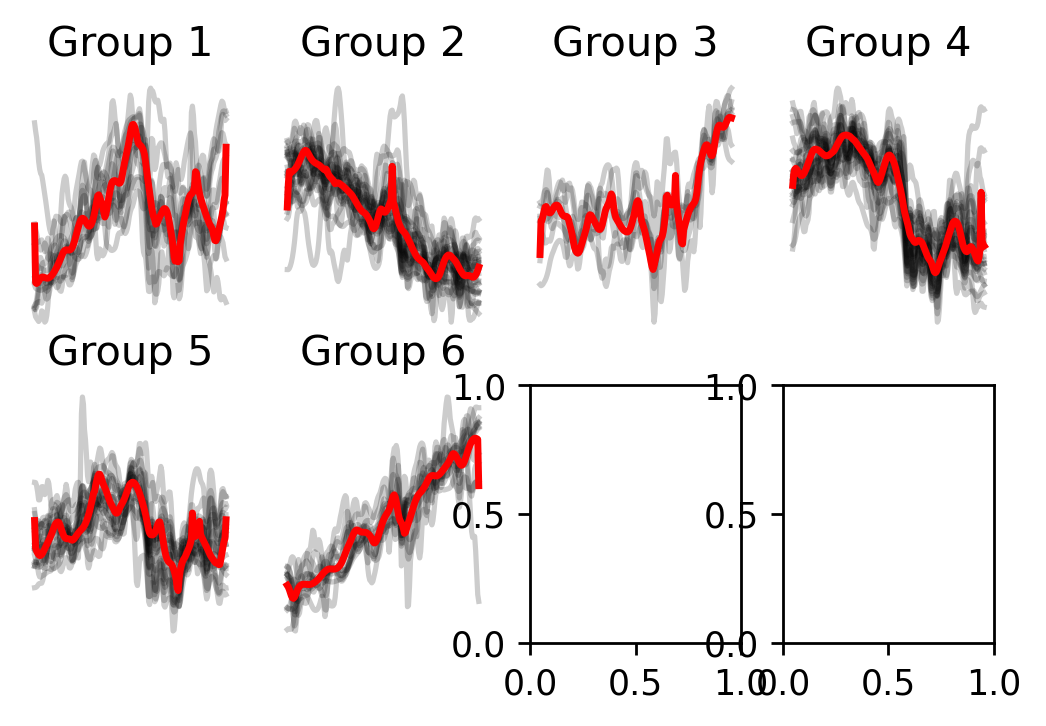

In [30]:
display_groups(data_2011, pred,class_num)

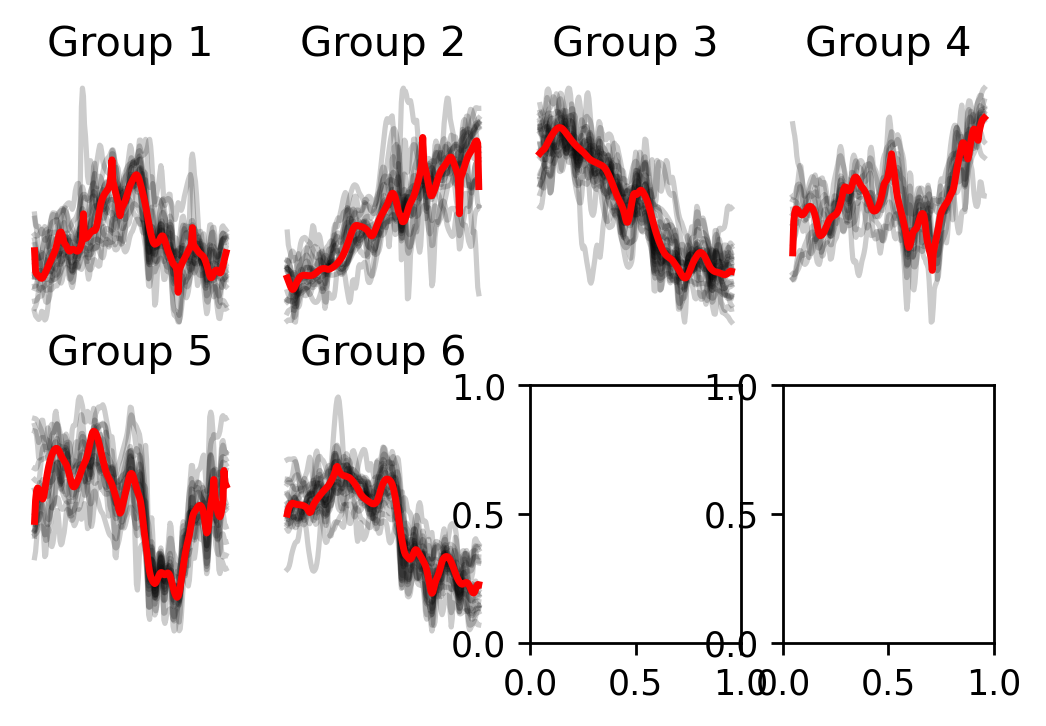

In [32]:
display_groups(data_2011, pred,class_num)

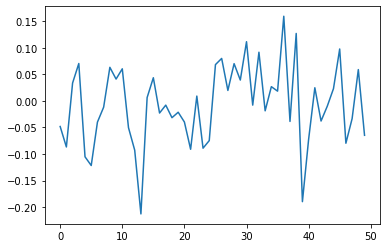

In [20]:
plt.plot(transformed[5])